In [3]:
!pip install pandas==2.3.3

  Using cached pandas-2.3.3-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.8 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]


In [6]:
import os
import cv2 as cv
import time
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
from IPython.display import display, clear_output

### Verificamos la detección de vehículos


image 1/1 /home/lcc_rn_05/YOLO-Speed-and-Plates-Detection/media/carro.jpeg: 448x640 8 persons, 7 cars, 93.5ms
Speed: 7.0ms preprocess, 93.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


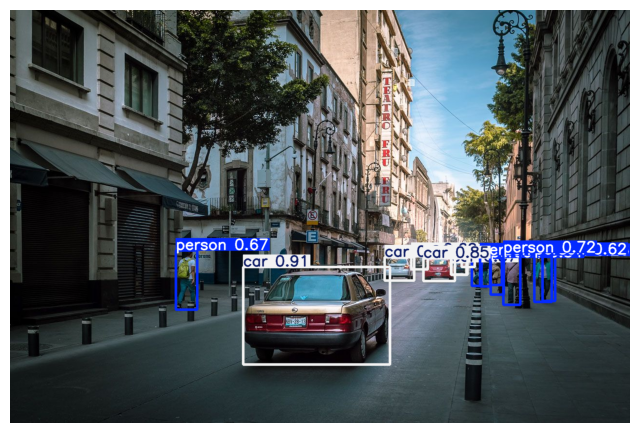

In [9]:
model = YOLO("yolov8s.pt")
results = model("media/carro.jpeg")

img = results[0].plot()

plt.figure(figsize=(8,8))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Añadimos traqueadores y IDs
Para poder seguirlos en un video y poder estimar su velocidad

In [10]:
tracker = sv.ByteTrack()

cap = cv.VideoCapture("media/tracker.mp4")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False)[0]

    #Convertimos detecciones a supervisión
    detections = sv.Detections.from_ultralytics(results)

    #Limitamos a solo carros
    detections = detections[detections.class_id == 2]

    #Asignamos ID
    tracked = tracker.update_with_detections(detections)

    annotated_frame = frame.copy()
    box_annotator = sv.BoxAnnotator()

    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=tracked,
        labels=[f"car #{track_id}" for track_id in tracked.tracker_id],
    )

    clear_output(wait=True)
    plt.imshow(cv.cvtColor(annotated_frame, cv.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

### Descargamos dataset y convertimos a formato YOLO

In [12]:
!pip install kagglehub

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)


In [13]:
import kagglehub

path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

print("Path to dataset files:", path)

100%|██████████| 203M/203M [00:04<00:00, 50.3MB/s] 

Extracting files...


Path to dataset files: /home/lcc_rn_05/.cache/kagglehub/datasets/andrewmvd/car-plate-detection/versions/1


In [14]:
import os
import xml.etree.ElementTree as ET

input_images = os.path.join(path, "images")
input_annotations = os.path.join(path, "annotations")

output_images = "data/images"
output_labels = "data/labels"

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

def convert_xml_to_yolo(xml_file, label_file, img_w, img_h):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    with open(label_file, "w") as f:
        for obj in root.findall("object"):
            cls = 0 

            xml_box = obj.find("bndbox")
            xmin = float(xml_box.find("xmin").text)
            ymin = float(xml_box.find("ymin").text)
            xmax = float(xml_box.find("xmax").text)
            ymax = float(xml_box.find("ymax").text)

            x_center = (xmin + xmax) / 2.0 / img_w
            y_center = (ymin + ymax) / 2.0 / img_h
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h

            f.write(f"{cls} {x_center} {y_center} {width} {height}\n")


In [15]:
import cv2
import shutil
from tqdm import tqdm

for xml in tqdm(os.listdir(input_annotations)):
    if not xml.endswith(".xml"):
        continue

    xml_path = os.path.join(input_annotations, xml)

    #nombre archivo imagen
    img_name = xml.replace(".xml", ".png")
    img_path = os.path.join(input_images, img_name)

    #cargar imagen
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    #copiar imagen a carpeta destino
    out_img = os.path.join(output_images, img_name)
    shutil.copy(img_path, out_img)

    #convertir anotaciones
    out_label = os.path.join(output_labels, xml.replace(".xml", ".txt"))
    convert_xml_to_yolo(xml_path, out_label, w, h)


100%|██████████| 433/433 [00:03<00:00, 135.03it/s]


### Entrenamos para detectar placas

In [16]:
# !yolo detect train model=yolov8s.pt data=license_data.yaml epochs=50 imgsz=640